In [1]:
import zarr
import random

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision

from skimage import transform

In [2]:
import matplotlib.pyplot as plt

In [3]:
import glob

# Setup the ViT model

In [56]:
weights = torchvision.models.vision_transformer.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1
vit_model = torchvision.models.vit_h_14(weights=weights, progress=False)

vit_model.heads = nn.Identity()
for par in vit_model.parameters():
    par.requires_grad = False
vit_model.eval()

classifier = nn.Linear(in_features=1280, out_features=1, bias=False)

In [57]:
vit_model.cuda()
classifier.cuda()

patch_size = 518

In [35]:
filenames = list(sorted(glob.glob("/projects/researchit/cervaf/Kidney/labeled_data/*.zarr")))

In [36]:
filenames[:5]

['/projects/researchit/cervaf/Kidney/labeled_data/0000.zarr',
 '/projects/researchit/cervaf/Kidney/labeled_data/0001.zarr',
 '/projects/researchit/cervaf/Kidney/labeled_data/0002.zarr',
 '/projects/researchit/cervaf/Kidney/labeled_data/0003.zarr',
 '/projects/researchit/cervaf/Kidney/labeled_data/0004.zarr']

In [37]:
len(filenames)

240

# Option 1: Resize to 518x518

In [38]:
from functools import partial

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    torchvision.transforms.Resize(size=(patch_size, patch_size), antialias=True)
])

In [39]:
import tqdm

inputs = []
for fn in tqdm.tqdm(filenames):
    z_grp = zarr.open(fn, mode="r")

    inputs.append((transforms(z_grp["0/0"][:].transpose(1, 2, 0)), # If the mage is height, width, channels, no need to transpose it 
                   np.max(z_grp["labels/0/0"])))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:10<00:00, 22.39it/s]


In [18]:
len(inputs)

240

In [40]:
dl = DataLoader(inputs,
                batch_size=2,
                num_workers=8,
                pin_memory=True,
                shuffle=True)

In [41]:
for x, y in dl:
    print(x.shape, m.shape, y.shape)


torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 518]) torch.Size([2]) torch.Size([2])
torch.Size([2, 3, 518, 5

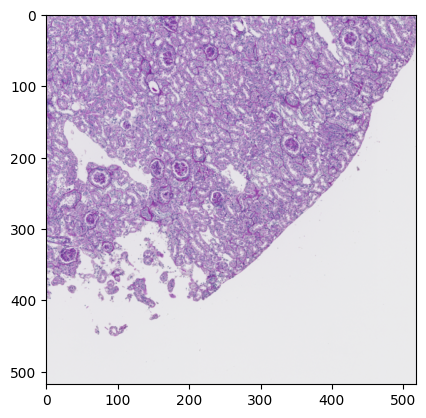

In [42]:
plt.imshow(x[0].permute(1, 2, 0) * torch.FloatTensor((0.229, 0.224, 0.225)) + torch.FloatTensor((0.485, 0.456, 0.406)))

In [43]:
y[0]

tensor(1, dtype=torch.uint8)

In [44]:
m[0]

tensor(1, dtype=torch.uint8)

In [47]:
criterion = torch.nn.BCEWithLogitsLoss()

In [58]:
fx = vit_model(x.cuda())
out = classifier(fx)

In [59]:
out.shape, out.device

(torch.Size([2, 1]), device(type='cuda', index=0))

In [60]:
loss = criterion(out, y.view(-1, 1).float().to(out.device))

In [61]:
loss

tensor(0.3321, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [62]:
loss.backward()

# Option 2: Split the image into 518x518 patches

In [27]:
from functools import partial

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(size=(patch_size * 2, patch_size * 2)),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

label_transforms = torchvision.transforms.Compose([
    lambda x: x.astype(np.uint8),
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.CenterCrop(size=(patch_size * 2, patch_size * 2)),
    lambda x: np.array(x),
])

In [81]:
import tqdm

inputs = []
for fn in tqdm.tqdm(filenames):
    z_grp = zarr.open(fn, mode="r")

    inputs.append((transforms(z_grp["0/0"][:].transpose(1, 2, 0)),
                   label_transforms(z_grp["labels/0/0"][0, ...]),
                   label_transforms(z_grp["labels/0/0"][0, ...])))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:10<00:00, 21.87it/s]


In [82]:
len(inputs)

240

In [83]:
dl = DataLoader(inputs, batch_size=2, num_workers=8, pin_memory=True, shuffle=True)

In [84]:
for x, m, y in dl:
    print(x.shape, m.shape, y.shape)


torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1036]) torch.Size([2, 2, 2]) torch.Size([2, 2, 2])
torch.Size([2, 3, 1036, 1

# The mask and labels will be too big to the expected output of the ViT model 518x518 -> 1x1

In [37]:
im = x[0].permute(1, 2, 0) * torch.FloatTensor((0.229, 0.224, 0.225)) + torch.FloatTensor((0.485, 0.456, 0.406))
t = y[0]
im_m = m[0]

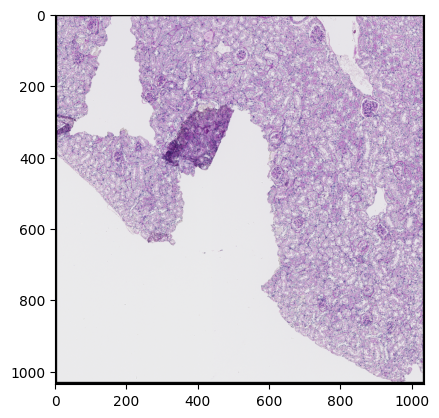

In [38]:
plt.imshow(im)

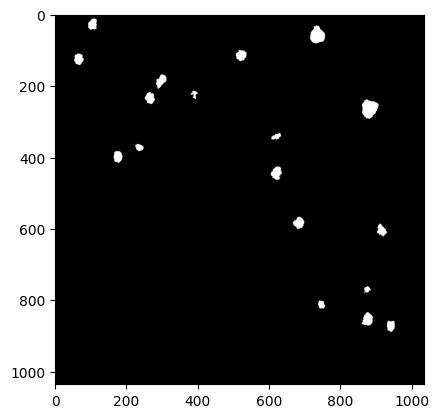

In [39]:
plt.imshow(t * 255, cmap="gray")

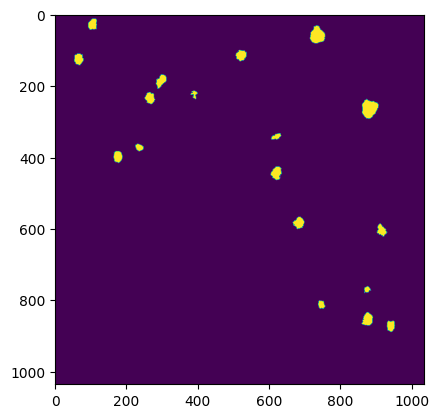

In [40]:
plt.imshow(im_m)

# Option 2: Part 2, downscale the masks and labels

In [85]:
from functools import partial

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(size=(patch_size * 2, patch_size * 2)),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

label_transforms = torchvision.transforms.Compose([
    lambda x: x.astype(np.uint8),
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.CenterCrop(size=(patch_size * 2, patch_size * 2)),
    torchvision.transforms.Resize(size=(2, 2), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
    lambda x: np.array(x),
])

In [86]:
import tqdm

inputs = []
for fn in tqdm.tqdm(filenames):
    z_grp = zarr.open(fn, mode="r")

    inputs.append((transforms(z_grp["0/0"][:].transpose(1, 2, 0)),
                   label_transforms(np.ones_like(z_grp["labels/0/0"][0, ...])),
                   label_transforms(z_grp["labels/0/0"][0, ...])))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:09<00:00, 26.62it/s]


In [87]:
dl = DataLoader(inputs, batch_size=1, num_workers=8, pin_memory=True, shuffle=True)

In [88]:
for x, m, y in dl:
    print(x.shape, m.shape, y.shape)


torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1036]) torch.Size([1, 2, 2]) torch.Size([1, 2, 2])
torch.Size([1, 3, 1036, 1

In [89]:
im = x[0].permute(1, 2, 0) * torch.FloatTensor((0.229, 0.224, 0.225)) + torch.FloatTensor((0.485, 0.456, 0.406))
im_t = y[0]
im_m = m[0]

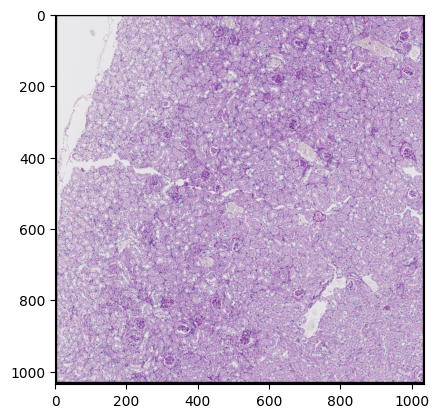

In [90]:
plt.imshow(im)

In [91]:
im_t

tensor([[0, 0],
        [0, 0]], dtype=torch.uint8)

In [92]:
im_m

tensor([[1, 1],
        [1, 1]], dtype=torch.uint8)

## Split the input to process with the ViT

In [93]:
b, c_in, h, w = x.shape
nh = h // patch_size
nw = w // patch_size

split_x = torch.nn.functional.unfold(x, kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size), padding=0)
split_x = split_x.transpose(1, 2).reshape(-1, c_in, patch_size, patch_size)

In [94]:
split_x.shape

torch.Size([4, 3, 518, 518])

In [95]:
split_fx = vit_model(split_x.cuda())
split_out = classifier(split_fx)

In [96]:
split_out.shape

torch.Size([4, 1])

In [97]:
out = split_out.transpose(1, 0).reshape(-1, nh, nw)

In [98]:
out.shape

torch.Size([1, 2, 2])

### Use reduction='none' so we can apply the tissue mask to the network output

In [99]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

In [100]:
unmasked_loss = criterion(out, y.float().to(out.device))
unmasked_loss

tensor([[[1.5105, 1.3543],
         [1.4479, 1.4259]]], device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

### Mask the loss function that was applied pixel-wise

In [101]:
masked_loss = unmasked_loss * m.float().to(loss.device)
masked_loss

tensor([[[1.5105, 1.3543],
         [1.4479, 1.4259]]], device='cuda:0', grad_fn=<MulBackward0>)

### Compute the actual loss as a weighted sum on pixels with tissue presence

In [102]:
loss = masked_loss.sum() / m.float().to(loss.device).sum()

In [103]:
loss.backward()

In [104]:
loss

tensor(1.4347, device='cuda:0', grad_fn=<DivBackward0>)